# Motor de redes neuronales

En el siguiente notebook explicamos la funcionalidad que se llevado a cabo para hacer el motor de redes neuronales.

En primer lugar, se crea la instancia llamando a los modulos pertinentes que contienen las implementaciones. Hemos intentado hacer una buena separación en módulos para mejorar, no solo el orden, sino también la claridad del código a la hora de usarlo sin necesidad de estar poniendo muchos comentarios, ya que eso es una mala práctica a la larga.

In [5]:
import numpy as np

In [6]:
from src.neural_network.neural_network import train, predict, create_nn, test_nn
from src.neural_network.utils.draw_nn import draw_nn
from src.neural_network.layers.activation.functions import Relu, Tanh, LeakyRelu
from src.neural_network.losses import mse, cross_entropy
from src.neural_network.utils.graphics.regression import learning_curve, dispersion_graph
from src.neural_network.optimizers.sgd import SGD
from src.neural_network.optimizers.adam import Adam
from src.neural_network.optimizers.adagrad import Adagrad
from src.neural_network.losses.cross_entropy import CrossEntropyLoss

In [7]:
optimizers = [
    Adagrad(learning_rate=0.07),
    Adagrad(learning_rate=0.07),
    Adagrad(learning_rate=0.07)
]

activations = [LeakyRelu(alpha=0.017), LeakyRelu(alpha=0.017), LeakyRelu(alpha=0.017)]

nn = create_nn([10, 8, 8, 3], activation_function=activations, optimizers=optimizers)

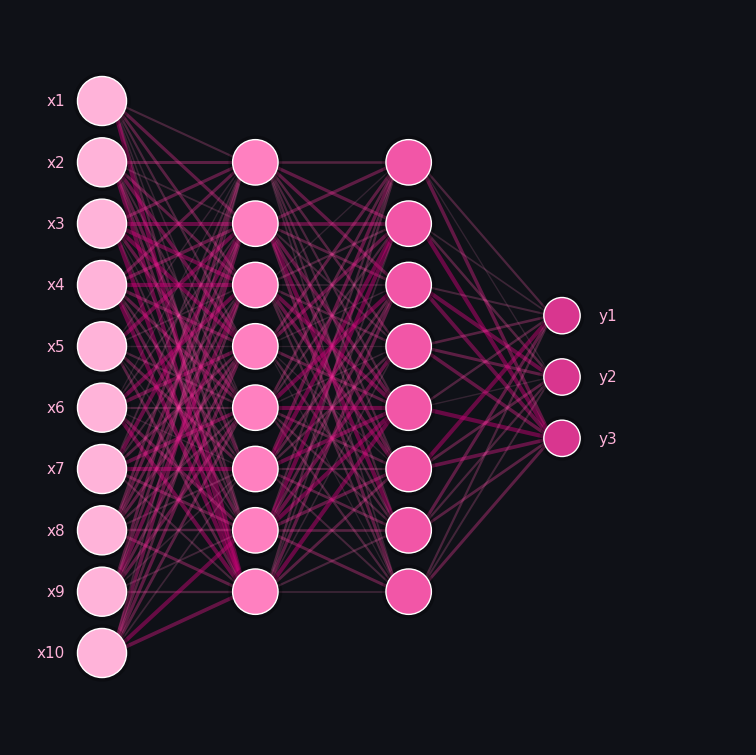

In [8]:
draw_nn(nn)


# Entrenamiento

La función **train** devuelve un historial del valor de pérdida durante el entrenamiento para poder hacer gráficas como las que se verán en las siguientes celdas.


Como parámetros necesita:
- La Red Neuronal
- La función de pérdida
- La derivada de la función de pérdida
- Los conjuntos de datos X, y
- Opcionalmente: Número de epochs, learning_rate y optimizador.


Es preciso que las variables X, y sean pasadas como arrays de numpy y tenga el siguiente shape:

- X.shape = (n_samples, n_features, 1)
- Y.shape = (n_samples, 1)

Esto se debe a que la red espera como datos de entrada un vector columna.

(Para simplicidad de la explicación vamos un conjunto de 
datos muy reducido tanto para entrenamiento como prueba, los experimentos reales se encuentran en el notebook testing de la carpeta tests)

In [9]:
X_train = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
y_train = np.array([[0], [1], [1], [1], [0], [0], [0]])

X_train = X_train.reshape((7, 3, 1))
y_train = y_train.reshape((7, 1))

optimizers = [Adam(learning_rate=0.01),
              Adam(learning_rate=0.01)]

activations = [Tanh(), Tanh()]

nn = create_nn([3, 2, 1], activation_function=activations, optimizers=optimizers)

loss = CrossEntropyLoss()

train_loss = train(nn, loss, X_train, y_train, epochs=700)